In [25]:
import pandas as pd

In [26]:
# Load the data from a CSV file
df = pd.read_csv('player_match_ratings.csv')

# Display the first few rows of the dataframe
print(df.head())

  competition        date                    match    team  pos pos_role  \
0   Euro 2016  10/06/2016  France - Romania, 2 - 1  France  Sub      Sub   
1   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   FW       FW   
2   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   DF       DC   
3   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   MF       MC   
4   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   MF       MC   

              player  goals  assists  shots_ontarget  ...  betweenness2goals  \
0    Anthony Martial      0        0               1  ...           0.000000   
1     Olivier Giroud      1        0               2  ...           0.050000   
2  Laurent Koscielny      0        0               0  ...           0.000000   
3       N'Golo Kante      0        1               0  ...           0.032258   
4         Paul Pogba      0        0               1  ...           0.000000   

   win  lost  is_home_team  minutesPlayed  game_duration  non_

In [27]:
import pandas as pd
import numpy as np

# ------------------
# Config
# ------------------
BASE_NOTE   = 6.926722   # initial player rating
K           = 0.35       # per-match learning rate
DIFF_IMPACT = 1.0        # how much opponent difficulty shifts expectation (rating pts)
MINUTES_CAP = 90         # cap for minutes weighting

# ------------------
# Helpers
# ------------------
def minutes_weight(m):
    if pd.isna(m): 
        return 0.0
    return float(np.clip(m / MINUTES_CAP, 0.0, 1.0))

def difficulty_from_rank(rank, max_rank):
    # rank=1 (best) -> difficulty=1 (hardest); rank=max_rank (worst) -> ~0 (easiest)
    if pd.isna(rank) or pd.isna(max_rank) or max_rank <= 1:
        return 0.5
    return 1.0 - (float(rank) - 1.0) / (float(max_rank) - 1.0)

def expected_performance(base_note, difficulty, diff_impact=DIFF_IMPACT):
    # Harder opponent => expectation lower than base_note; easier => higher
    return base_note - diff_impact * (difficulty - 0.5) * 2.0

# ------------------
# Load & prep
# ------------------
pm = pd.read_csv("player_match_ratings.csv")

# Ensure proper dtypes & order
pm["date"] = pd.to_datetime(pm["date"], errors="coerce")
pm = pm.sort_values(["date", "match", "player"]).reset_index(drop=True)

# Performance P = average of human & non-human notes (ignore NaNs)
pm["P"] = pm[["human_rating", "non_human_rating"]].mean(axis=1)

# Minutes weighting
pm["w_min"] = pm["minutesPlayed"].apply(minutes_weight)

# Competition-wise max rank to scale opponent_ranking → difficulty in [0,1]
max_rank_df = (
    pm.groupby("competition", dropna=False)["opponent_ranking"]
      .max()
      .rename("max_rank")
      .reset_index()
)
pm = pm.merge(max_rank_df, on="competition", how="left")
pm["difficulty"] = pm.apply(
    lambda r: difficulty_from_rank(r["opponent_ranking"], r["max_rank"]), axis=1
)

# ------------------
# Elo-like update loop
# ------------------

def compute_ratings(pm, K=0.35, DIFF_IMPACT=1.0):
    # pm : DataFrame player_match_ratings
    player_rating = {}
    history = []

    for row in pm.itertuples(index=False):
        player = row.player
        perf   = row.P
        w_min  = row.w_min
        diff   = row.difficulty
        date   = row.date
        match  = row.match

        R_old = player_rating.get(player, BASE_NOTE)

        if pd.isna(perf):
            history.append((date, match, player, R_old, np.nan, np.nan, R_old))
            continue

        E = expected_performance(BASE_NOTE, diff, DIFF_IMPACT)
        delta = K * w_min * (perf - E)
        R_new = R_old + delta

        player_rating[player] = R_new
        history.append((date, match, player, R_old, perf, E, R_new))

    ratings_ts = pd.DataFrame(history, columns=["date","match","player","rating_before","P","E","rating_after"])
    final_ratings = (ratings_ts.sort_values("date")
                     .groupby("player", as_index=False)["rating_after"]
                     .last()
                     .rename(columns={"rating_after":"final_rating"}))
    return ratings_ts, final_ratings


top_20    = final_ratings.sort_values("final_rating", ascending=False).head(20)
bottom_20 = final_ratings.sort_values("final_rating", ascending=True).head(20)


print(top_20)
print(bottom_20)


                player  final_rating
260    Kevin De Bruyne     28.443017
137        Eden Hazard     22.979437
355      Mohamed Salah     20.222572
285         Leroy Sane     19.615598
449      Sergio Aguero     18.679780
178         Harry Kane     18.056165
113        David Silva     17.517424
84   Christian Eriksen     17.281103
413    Raheem Sterling     16.764563
419       Riyad Mahrez     15.504746
363              Naldo     15.234692
421    Roberto Firmino     14.596833
435         Salif Sane     14.468129
201    James Rodriguez     14.250445
510      Wilfried Zaha     14.143780
451        Shane Duffy     14.125703
153        Fernandinho     14.014056
54             Ben Mee     13.916350
244     Joshua Kimmich     13.855334
179      Harry Maguire     13.598122
                  player  final_rating
61            Bobby Wood      0.156378
521           Yuya Osako      0.772563
169          Gideon Jung      0.833719
356  Morgan Schneiderlin      0.898393
323        Martin Olsson    

In [28]:
for K_test in [0.2, 0.35, 0.5]:
    for diff_test in [0.5, 1.0, 1.5]:
        ratings_ts, final_ratings = compute_ratings(pm, K=K_test, DIFF_IMPACT=diff_test)
        top5 = final_ratings.sort_values('final_rating', ascending=False).head(5)
        print(f"\nK={K_test}, DIFF_IMPACT={diff_test} -> Top 5 players:")
        print(top5[['player', 'final_rating']])



K=0.2, DIFF_IMPACT=0.5 -> Top 5 players:
              player  final_rating
260  Kevin De Bruyne     15.912187
137      Eden Hazard     13.318919
355    Mohamed Salah     12.678746
113      David Silva     12.169670
178       Harry Kane     11.993704

K=0.2, DIFF_IMPACT=1.0 -> Top 5 players:
              player  final_rating
260  Kevin De Bruyne     15.722714
137      Eden Hazard     13.333364
355    Mohamed Salah     12.461904
285       Leroy Sane     11.935840
178       Harry Kane     11.686101

K=0.2, DIFF_IMPACT=1.5 -> Top 5 players:
              player  final_rating
260  Kevin De Bruyne     15.533240
137      Eden Hazard     13.347808
355    Mohamed Salah     12.245062
285       Leroy Sane     12.002273
449    Sergio Aguero     11.627945

K=0.35, DIFF_IMPACT=0.5 -> Top 5 players:
              player  final_rating
260  Kevin De Bruyne     22.651286
137      Eden Hazard     18.113067
355    Mohamed Salah     16.992765
113      David Silva     16.101880
178       Harry Kane     1

In [29]:
import pandas as pd
import numpy as np

# ------------------
# Config
# ------------------
BASE_NOTE   = 6.926722   # initial player rating
K           = 0.35       # per-match learning rate
DIFF_IMPACT = 1.0        # how much opponent difficulty shifts expectation (rating pts)
MINUTES_CAP = 90         # cap for minutes weighting

# ------------------
# Helpers
# ------------------
def minutes_weight(m):
    if pd.isna(m):
        return 0.0
    return float(np.clip(m / MINUTES_CAP, 0.0, 1.0))

def difficulty_from_rank(rank, max_rank):
    # rank=1 (best) -> difficulty=1 (hardest); rank=max_rank (worst) -> ~0 (easiest)
    if pd.isna(rank) or pd.isna(max_rank) or max_rank <= 1:
        return 0.5
    return 1.0 - (float(rank) - 1.0) / (float(max_rank) - 1.0)

def expected_performance(base_note, difficulty, diff_impact=DIFF_IMPACT):
    # Harder opponent => expectation lower than base_note; easier => higher
    return base_note - diff_impact * (difficulty - 0.5) * 2.0

def compute_ratings(pm, K=K, diff_impact=DIFF_IMPACT):
    """
    pm must contain: ['date','match','player','w_min','difficulty','P']
    Returns: (ratings_ts, final_ratings)
    """
    player_rating = {}
    history = []

    for row in pm.itertuples(index=False):
        player = row.player
        perf   = row.P
        w_min  = row.w_min
        diff   = row.difficulty
        date   = row.date
        match  = row.match

        R_old = player_rating.get(player, BASE_NOTE)

        if pd.isna(perf):
            history.append((date, match, player, R_old, np.nan, np.nan, R_old))
            continue

        E = expected_performance(BASE_NOTE, diff, diff_impact)
        delta = K * w_min * (perf - E)
        R_new = R_old + delta

        player_rating[player] = R_new
        history.append((date, match, player, R_old, perf, E, R_new))

    ratings_ts = pd.DataFrame(history, columns=["date","match","player","rating_before","P","E","rating_after"])
    final_ratings = (ratings_ts.sort_values("date")
                     .groupby("player", as_index=False)["rating_after"]
                     .last()
                     .rename(columns={"rating_after":"final_rating"}))
    return ratings_ts, final_ratings

# ------------------
# Load & prep (once)
# ------------------
pm0 = pd.read_csv("player_match_ratings.csv")
pm0["date"] = pd.to_datetime(pm0["date"], errors="coerce")
pm0 = pm0.sort_values(["date", "match", "player"]).reset_index(drop=True)

# Minutes weighting
pm0["w_min"] = pm0["minutesPlayed"].apply(minutes_weight)

# Difficulty from opponent rank, scaled per competition
max_rank_df = (
    pm0.groupby("competition", dropna=False)["opponent_ranking"]
       .max().rename("max_rank").reset_index()
)
pm0 = pm0.merge(max_rank_df, on="competition", how="left")
pm0["difficulty"] = pm0.apply(
    lambda r: difficulty_from_rank(r["opponent_ranking"], r["max_rank"]), axis=1
)

# ------------------
# Build three datasets with their own P
# ------------------
base_cols = ["date","match","player","w_min","difficulty"]

# 1) Average of human & non-human (ignores NaNs automatically)
pm_avg = pm0[base_cols].copy()
pm_avg["P"] = pm0[["human_rating","non_human_rating"]].mean(axis=1)

# 2) Human-only
pm_hum = pm0[base_cols].copy()
pm_hum["P"] = pm0["human_rating"]

# 3) Non-human-only
pm_ai = pm0[base_cols].copy()
pm_ai["P"] = pm0["non_human_rating"]

# ------------------
# Compute ratings for each system
# ------------------
ts_avg, fin_avg = compute_ratings(pm_avg)
ts_hum, fin_hum = compute_ratings(pm_hum)
ts_ai,  fin_ai  = compute_ratings(pm_ai)

# Label and stack time series
ts_avg["system"] = "average"
ts_hum["system"] = "human"
ts_ai["system"]  = "ai"
ts_all = pd.concat([ts_avg, ts_hum, ts_ai], ignore_index=True)

# Merge final ratings (wide)
fin_avg = fin_avg.rename(columns={"final_rating":"final_rating_avg"})
fin_hum = fin_hum.rename(columns={"final_rating":"final_rating_human"})
fin_ai  = fin_ai.rename(columns={"final_rating":"final_rating_ai"})

final_all = (fin_avg
             .merge(fin_hum, on="player", how="outer")
             .merge(fin_ai,  on="player", how="outer"))

# ------------------
# Save two CSVs
# ------------------
final_all.to_csv("final_ratings_three_systems.csv", index=False)
ts_all.to_csv("ratings_timeseries_three_systems.csv", index=False)

# (optional)
print("Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv")


Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv


In [47]:
# Show the 10 best players by each rating system
print("Top 10 by average note:")
print(final_all.sort_values("final_rating_avg", ascending=False)[["player", "final_rating_avg"]].head(10))

print("\nTop 5 by human note:")
print(final_all.sort_values("final_rating_human", ascending=False)[["player", "final_rating_human"]].head(5))

print("\nTop 5 by non-human note:")
print(final_all.sort_values("final_rating_ai", ascending=False)[["player", "final_rating_ai"]].head(5))

Top 10 by average note:
                player  final_rating_avg
260    Kevin De Bruyne         22.319707
137        Eden Hazard         18.138345
355      Mohamed Salah         16.613291
285         Leroy Sane         15.692678
178         Harry Kane         15.255636
113        David Silva         15.221047
449      Sergio Aguero         15.096348
413    Raheem Sterling         14.536032
84   Christian Eriksen         14.334233
363              Naldo         13.040830

Top 5 by human note:
              player  final_rating_human
260  Kevin De Bruyne           23.581448
355    Mohamed Salah           17.306502
113      David Silva           16.659118
285       Leroy Sane           16.172174
413  Raheem Sterling           15.975707

Top 5 by non-human note:
              player  final_rating_ai
260  Kevin De Bruyne        21.057966
137      Eden Hazard        20.825093
178       Harry Kane        17.892283
355    Mohamed Salah        15.920080
449    Sergio Aguero        15.591358


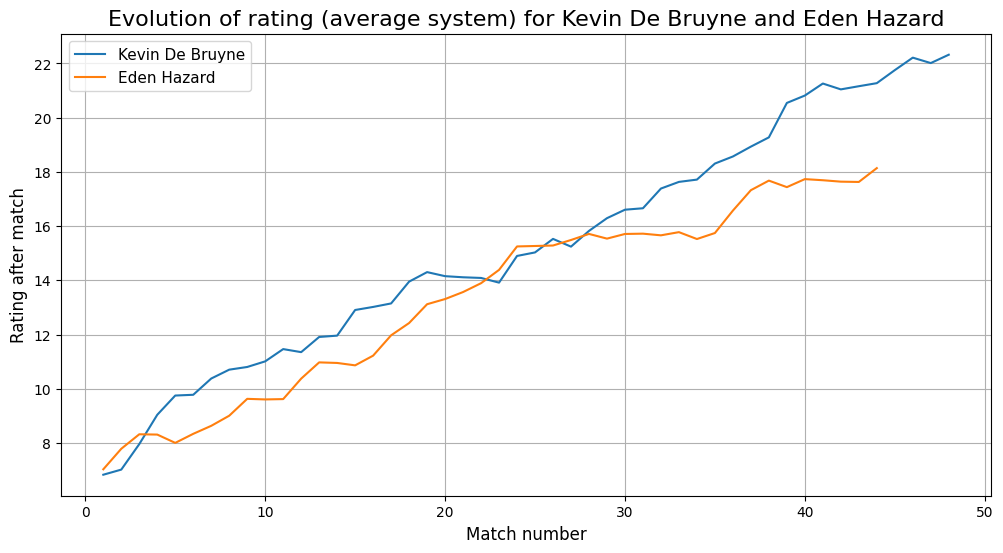

In [48]:
import matplotlib.pyplot as plt

# Filter for Kevin De Bruyne and Eden Hazard in the average system
players = ["Kevin De Bruyne", "Eden Hazard"]
df_plot = ts_avg[ts_avg["player"].isin(players)].copy()

# Add match number per player
df_plot["match_number"] = df_plot.groupby("player").cumcount() + 1

plt.figure(figsize=(12, 6))
for player in players:
    player_data = df_plot[df_plot["player"] == player]
    plt.plot(player_data["match_number"], player_data["rating_after"], label=player)

plt.xlabel("Match number")
plt.ylabel("Rating after match")
plt.title("Evolution of rating (average system) for Kevin De Bruyne and Eden Hazard")
plt.legend()
plt.grid(True)
plt.show()

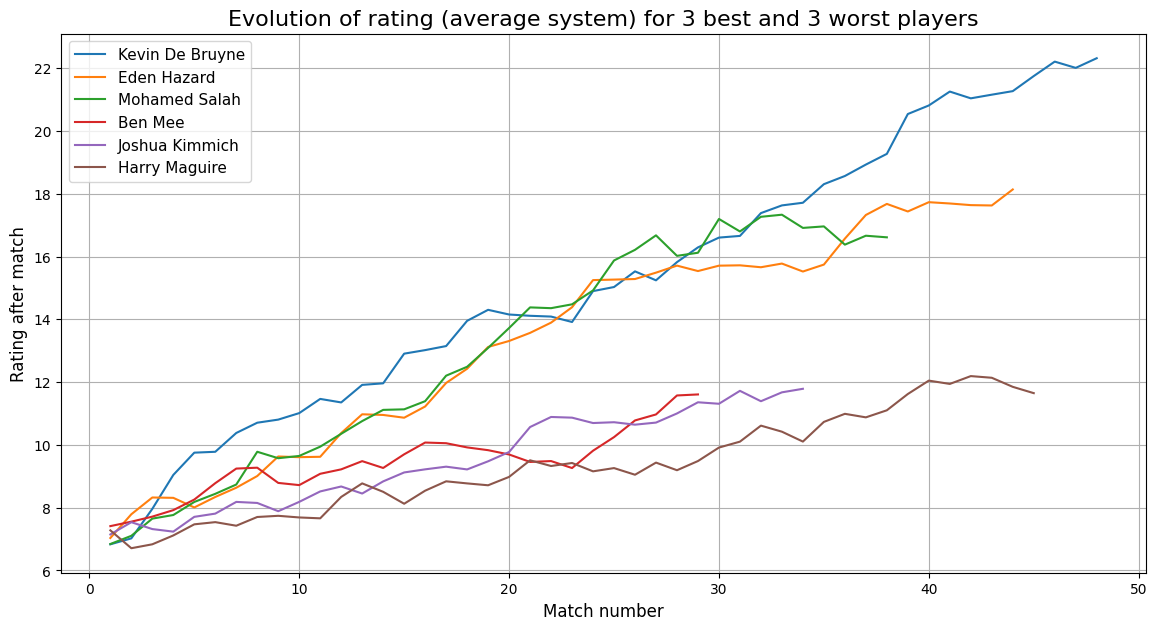

In [49]:
import matplotlib.pyplot as plt

# Get top 3 and bottom 3 players by final_rating
best_players = top_20.head(3)["player"].tolist()
worst_players = top_20.tail(3)["player"].tolist()

# Combine for plotting
players_to_plot = best_players + worst_players

# Filter time series for these players (average system)
df_plot = ts_avg[ts_avg["player"].isin(players_to_plot)].copy()
df_plot["match_number"] = df_plot.groupby("player").cumcount() + 1

plt.figure(figsize=(14, 7))
for player in players_to_plot:
    player_data = df_plot[df_plot["player"] == player]
    plt.plot(player_data["match_number"], player_data["rating_after"], label=player)

plt.xlabel("Match number")
plt.ylabel("Rating after match")
plt.title("Evolution of rating (average system) for 3 best and 3 worst players")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
import pandas as pd
import numpy as np

# ------------------
# Config
# ------------------
BASE_NOTE   = 6.926722
K           = 0.35
DIFF_IMPACT = 1.0      # difficulty effect (rating pts)
DECAY       = 0.02     # small mean-reversion per match (0 = off)
ANCHOR_MATCHDAY = True # center P by comp+date mean to keep totals neutral

# ------------------
# Helpers
# ------------------
def minutes_weight(m):
    if pd.isna(m):
        return 0.0
    return float(np.clip(m / MINUTES_CAP, 0.0, 1.0))

def difficulty_from_rank(rank, max_rank):
    # rank=1 (best) -> difficulty=1 (hardest); rank=max_rank (worst) -> ~0 (easiest)
    if pd.isna(rank) or pd.isna(max_rank) or max_rank <= 1:
        return 0.5
    return 1.0 - (float(rank) - 1.0) / (float(max_rank) - 1.0)

def expected_performance(base_note, difficulty, diff_impact=DIFF_IMPACT):
    # Harder opponent => expectation lower than base_note; easier => higher
    return base_note - diff_impact * (difficulty - 0.5) * 2.0

# -------- Stable Elo variant (smooth + clipped + mean-calibrated) --------
BASE_NOTE     = 6.926722
K             = 0.25      # a bit slower than 0.35 for stability
DIFF_IMPACT   = 1.0
DECAY         = 0.005     # gentle pull to base
EMA_ALPHA     = 0.30      # smoothing of match performance (0=no smoothing, 1=raw)
DELTA_CLIP    = 0.30      # cap per-match change in rating
ANCHOR_MATCHDAY = True     # center P by competition+date
TARGET_MEAN   = BASE_NOTE  # keep final average at this value (order preserved)

def compute_ratings(pm, perf_col="P",
                    K=K, diff_impact=DIFF_IMPACT, decay=DECAY,
                    ema_alpha=EMA_ALPHA, delta_clip=DELTA_CLIP,
                    anchor_matchday=ANCHOR_MATCHDAY, target_mean=TARGET_MEAN):
    """
    pm must have: ['date','match','player','w_min','difficulty', perf_col] and 'competition' if anchoring is True.
    Returns: (ratings_ts, final_ratings)
    """
    import pandas as pd
    import numpy as np

    df = pm.copy()
    df = df.sort_values(["date","match","player"])

    # 1) Optional anchoring (removes matchday-wide drift)
    can_anchor = anchor_matchday and {"competition","date"}.issubset(df.columns)
    if can_anchor:
        mday_mean = df.groupby(["competition","date"], dropna=False)[perf_col].transform("mean")
        df["P_base"] = df[perf_col] - mday_mean + BASE_NOTE
    else:
        df["P_base"] = df[perf_col]

    # 2) Per-player EMA of performance for stability
    df["P_eff"] = np.nan
    last_ema = {}  # player -> EMA
    for i, r in enumerate(df.itertuples(index=False)):
        p = r.player
        cur = getattr(r, "P_base")
        prev = last_ema.get(p, BASE_NOTE)
        ema  = ema_alpha * cur + (1 - ema_alpha) * prev
        last_ema[p] = ema
        df.iat[i, df.columns.get_loc("P_eff")] = ema

    # 3) Elo-like loop with clipping & decay
    player_rating = {}
    hist = []
    for r in df.itertuples(index=False):
        date, match, player = r.date, r.match, r.player
        perf, w_min, diff = r.P_eff, r.w_min, r.difficulty

        R_old = player_rating.get(player, BASE_NOTE)
        E = R_old - diff_impact * (diff - 0.5) * 2.0

        delta = K * float(w_min) * (perf - E)
        if delta_clip is not None:
            delta = float(np.clip(delta, -delta_clip, delta_clip))

        R_new = R_old + delta + decay * (BASE_NOTE - R_old)
        player_rating[player] = R_new
        hist.append((date, match, player, R_old, perf, E, R_new))

    ratings_ts = pd.DataFrame(hist, columns=["date","match","player","rating_before","P_eff","E","rating_after"])

    # 4) Final ratings
    final_ratings = (ratings_ts.sort_values("date")
                     .groupby("player", as_index=False)["rating_after"]
                     .last()
                     .rename(columns={"rating_after":"final_rating_raw"}))

    # 5) Keep the same global mean (order preserved)
    cur_mean = final_ratings["final_rating_raw"].mean()
    shift = (target_mean - cur_mean)
    final_ratings["final_rating"] = final_ratings["final_rating_raw"] + shift
    final_ratings = final_ratings.drop(columns=["final_rating_raw"])

    return ratings_ts, final_ratings


# ------------------
# Load & prep (once)
# ------------------
pm0 = pd.read_csv("player_match_ratings.csv")
pm0["date"] = pd.to_datetime(pm0["date"], errors="coerce")
pm0 = pm0.sort_values(["date", "match", "player"]).reset_index(drop=True)

# Minutes weighting
pm0["w_min"] = pm0["minutesPlayed"].apply(minutes_weight)

# Difficulty from opponent rank, scaled per competition
max_rank_df = (
    pm0.groupby("competition", dropna=False)["opponent_ranking"]
       .max().rename("max_rank").reset_index()
)
pm0 = pm0.merge(max_rank_df, on="competition", how="left")
pm0["difficulty"] = pm0.apply(
    lambda r: difficulty_from_rank(r["opponent_ranking"], r["max_rank"]), axis=1
)


# ------------------
# Build three datasets with their own P
# ------------------
# Make sure these columns exist in pm0 before this block:
# ['date','match','player','competition','w_min','difficulty','human_rating','non_human_rating']

base_cols = ["date","match","player","competition","w_min","difficulty"]

pm_avg = pm0[base_cols].copy()
pm_avg["P"] = pm0[["human_rating","non_human_rating"]].mean(axis=1)

pm_hum = pm0[base_cols].copy()
pm_hum["P"] = pm0["human_rating"]

pm_ai  = pm0[base_cols].copy()
pm_ai["P"]  = pm0["non_human_rating"]

# Compute ratings for each system (average / human-only / ai-only)
ts_avg, fin_avg = compute_ratings(pm_avg, perf_col="P")
ts_hum, fin_hum = compute_ratings(pm_hum, perf_col="P")
ts_ai,  fin_ai  = compute_ratings(pm_ai,  perf_col="P")


# Label and stack time series
ts_avg["system"] = "average"
ts_hum["system"] = "human"
ts_ai["system"]  = "ai"
ts_all = pd.concat([ts_avg, ts_hum, ts_ai], ignore_index=True)

# Merge final ratings (wide)
fin_avg = fin_avg.rename(columns={"final_rating":"final_rating_avg"})
fin_hum = fin_hum.rename(columns={"final_rating":"final_rating_human"})
fin_ai  = fin_ai.rename(columns={"final_rating":"final_rating_ai"})

final_all = (fin_avg
             .merge(fin_hum, on="player", how="outer")
             .merge(fin_ai,  on="player", how="outer"))

# ------------------
# Save two CSVs
# ------------------
final_all.to_csv("final_ratings_three_systems.csv", index=False)
ts_all.to_csv("ratings_timeseries_three_systems.csv", index=False)

# (optional)
print("Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv")


Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv


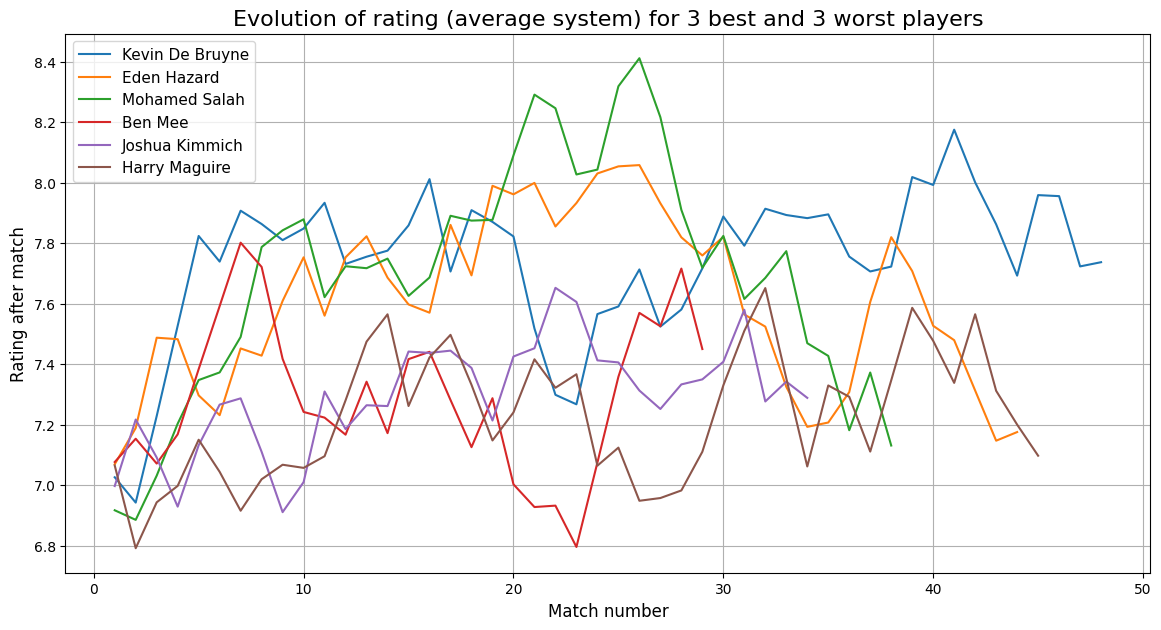

In [57]:
import matplotlib.pyplot as plt

# Get top 3 and bottom 3 players by final_rating
best_players = top_20.head(3)["player"].tolist()
worst_players = top_20.tail(3)["player"].tolist()

# Combine for plotting
players_to_plot = best_players + worst_players

# Filter time series for these players (average system)
df_plot = ts_avg[ts_avg["player"].isin(players_to_plot)].copy()
df_plot["match_number"] = df_plot.groupby("player").cumcount() + 1

plt.figure(figsize=(14, 7))
for player in players_to_plot:
    player_data = df_plot[df_plot["player"] == player]
    plt.plot(player_data["match_number"], player_data["rating_after"], label=player)

plt.xlabel("Match number")
plt.ylabel("Rating after match")
plt.title("Evolution of rating (average system) for 3 best and 3 worst players")
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Show the 10 best players by each rating system
print("Top 10 by average note:")
print(final_all.sort_values("final_rating_avg", ascending=False)[["player", "final_rating_avg"]].head(10))

Top 10 by average note:
              player  final_rating_avg
260  Kevin De Bruyne          7.855336
411          Raffael          7.824020
449    Sergio Aguero          7.795273
276      Lars Bender          7.789598
413  Raheem Sterling          7.789192
277      Lars Stindl          7.768357
360       Naby Keita          7.757690
307  Marcel Sabitzer          7.744794
419     Riyad Mahrez          7.676274
285       Leroy Sane          7.626743
